# Tutorial - Iris data 

In this tutorial, we present the basic usage of the Bayesian PCA algorithm on the **Iris dataset**, for which we artificially introduce missing values completely at random. We compare the performance of the bayesian PCA algorithm with the _classic_ PCA algorithm and across various missingness values.

## Setup

### Imports

In [60]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist
from bpca import BPCA
import matplotlib as mpl

### Functions
We define some helper functions that help us to introduce missing data into the dataset and help us to evaluate the performance of the bayesian PCA compared to the standard PCA workflow

In [61]:
def introduce_missing_values(X: np.ndarray, p_missing: float) -> np.ndarray:
    """Introduce missing values completely at random

    Parameters
    ----------
    X
        Complete data (n_obs, n_var)
    p_missing
        Probability for a value to be missing

    Returns
    -------
    numpy.ndarrary
        Copy of array with shape (n_obs, n_var) with missing values as np.nan. Note that while the probability of a missing value
        in the generative process is `p_missing`, but the fraction of actually missing values might differ from this
    """
    X = X.astype(float).copy()
    mask = np.random.choice([True, False], size=X.shape, p=[p, 1 - p], replace=True)
    X[mask] = np.nan

    return X

In [62]:
def plot_pca(
    usage: np.ndarray,
    c: np.ndarray,
    explained_variance: np.ndarray | None = None,
    ax: mpl.axes.Axes | None = None,
    title: str | None = None,
) -> mpl.axes.Axes:
    """PCA plot"""
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(4, 4))

    ax.scatter(usage[:, 0], usage[:, 1], marker="o", linestyle="", c=species)

    if title is not None:
        ax.set_title(title, loc="left")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines[["top", "right"]].set_visible(False)

    ax.set_xlabel(f"PC1 - {explained_variance[0] * 100:.0f}%")
    ax.set_ylabel(f"PC2 - {explained_variance[1] * 100:.0f}%")

    return ax

In [63]:
def mean_correlation(query: np.ndarray, reference: np.ndarray) -> float:
    """Compute median correlation between a query and its reference"""
    pairwise_correlation = (cdist(query, reference, metric="correlation") - 1) ** 2
    pairwise_correlation[np.isnan(pairwise_correlation)] = 0
    query_idx, reference_idx = linear_sum_assignment(pairwise_correlation, maximize=True)

    return float(np.mean(pairwise_correlation[query_idx, reference_idx]))

## Run

**Dataset** We use the Iris dataset that measures 4 different features from 150 orchidee samples of 3 different plant species. 

In [64]:
iris_dataset = load_iris()
X = iris_dataset["data"]
species = iris_dataset["target"]

We will run the **BPCA** workflow with different missingness patterns. 

In [65]:
probabilities = [0, 0.1, 0.25, 0.5, 0.75]

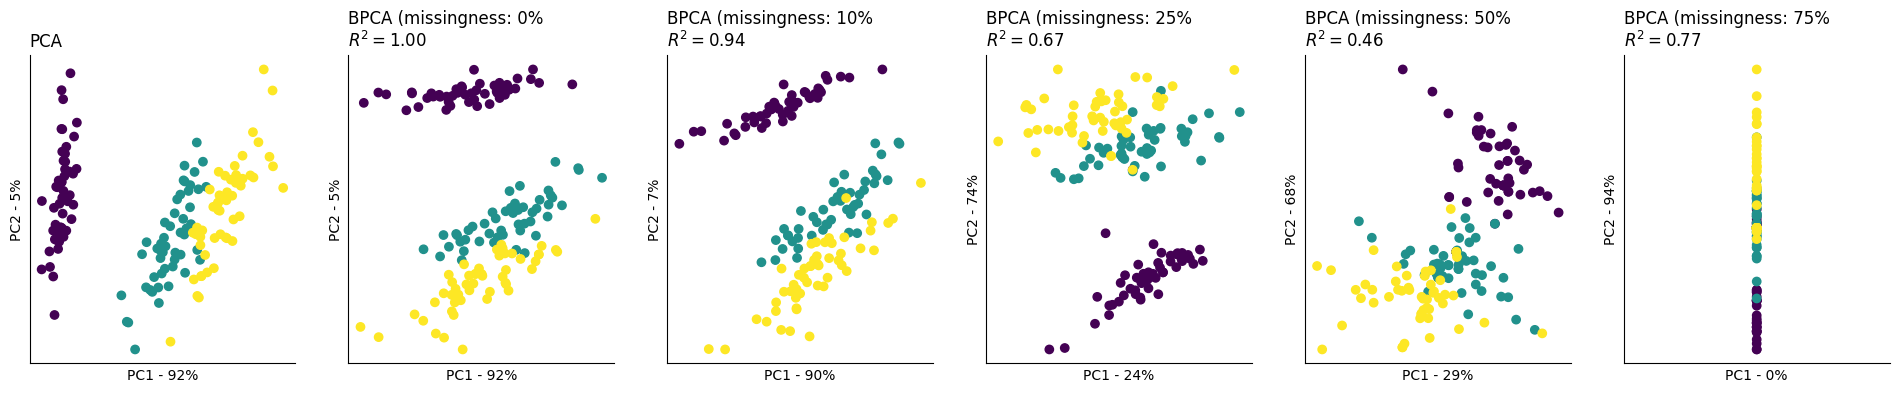

In [66]:
fig, axs = plt.subplots(1, 1 + len(probabilities), figsize=(4 * (1 + len(probabilities)), 4))

# Run default PCA with sklearn
pca = PCA(n_components=2)
pca_usage = pca.fit_transform(X)
explained_variance_ratio = pca.explained_variance_ratio_
plot_pca(usage=pca_usage, c=species, explained_variance=explained_variance_ratio, ax=axs[0], title="PCA")

for p, ax in zip(probabilities, axs[1:].ravel(), strict=True):
    X_missing = introduce_missing_values(X, p_missing=p)

    bpca = BPCA(n_components=2)
    usage = bpca.fit_transform(X_missing)
    explained_variance = bpca.explained_variance_ratio_

    r2 = mean_correlation(query=usage.T, reference=pca_usage.T)

    title = f"BPCA (missingness: {p * 100:.0f}%\n$R^2={r2:.2f}$"

    # Plot
    plot_pca(
        usage=usage[:, np.argsort(explained_variance)],
        c=species,
        explained_variance=explained_variance,
        ax=ax,
        title=title,
    )

For low missingness values, BPCA correctly recovers the PCA results. The higher the missingness, the more the performance degrades.